<a href="https://colab.research.google.com/github/eneskacan/agu-capstone/blob/main/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [64]:
# Define external URLs
DOWNLOAD_ROOT = "https://raw.githubusercontent.com/eneskacan/agu-capstone/main/"
VEHICLES_DATA = DOWNLOAD_ROOT + "dataset/class_5.csv"

In [153]:
# Import dataset (class_5.csv)
import pandas as pd

X_df = pd.read_csv(VEHICLES_DATA, header=None).iloc[: , :-1] # drop the last column
y_df = pd.read_csv(VEHICLES_DATA, header=None).iloc[: , -1:] # pick the last column

vehicle_df = pd.concat([X_df, y_df], axis=1)

pd.set_option("display.max_columns", 15) # limit max number of columns displayed
vehicle_df.head()

,0,1,2,3,4,5,6,...,615,616,617,618,619,620,621
0,-4646,-4635,-4621,-4622,-4637,-4689,-4789,...,0,0,0,0,0,0,hatchback
1,-4500,-4551,-4581,-4529,-4514,-4564,-4616,...,0,0,0,0,0,0,hatchback
2,-4333,-4326,-4329,-4329,-4327,-4331,-4325,...,0,0,0,0,0,0,hatchback
3,-4308,-4304,-4300,-4302,-4293,-4284,-4270,...,0,0,0,0,0,0,hatchback
4,-4765,-4763,-4766,-4757,-4758,-4754,-4755,...,0,0,0,0,0,0,hatchback


In [154]:
# Data Preprocessing
import numpy as np

X_df = X_df.replace(0, np.NaN) # replace zeros with null

# Find mean values for each signal
X_df['x_avg'] = X_df.iloc[:, 000:206].mean(axis=1)
X_df['y_avg'] = X_df.iloc[:, 207:414].mean(axis=1)
X_df['z_avg'] = X_df.iloc[:, 415:621].mean(axis=1)

# Find minimum values for each signal
X_df['x_min'] = X_df.iloc[:, 000:206].min(axis=1)
X_df['y_min'] = X_df.iloc[:, 207:414].min(axis=1)
X_df['z_min'] = X_df.iloc[:, 415:621].min(axis=1)

# Find maximum values for each signal
X_df['x_max'] = X_df.iloc[:, 000:206].max(axis=1)
X_df['y_max'] = X_df.iloc[:, 207:414].max(axis=1)
X_df['z_max'] = X_df.iloc[:, 415:621].max(axis=1)

# Find standard deviation for each signal
X_df['x_std'] = X_df.iloc[:, 000:206].std(axis=1)
X_df['y_std'] = X_df.iloc[:, 207:414].std(axis=1)
X_df['z_std'] = X_df.iloc[:, 415:621].std(axis=1)

# Drop redundant columns
X_df.drop(X_df.iloc[:, 0:621], inplace = True, axis = 1)
X_df.head()

,x_avg,y_avg,z_avg,x_min,y_min,z_min,x_max,y_max,z_max,x_std,y_std,z_std
0,-4597.514286,4013.457143,2659.823529,-4953.0,3276.0,1285.0,-4253.0,4894.0,3116.0,172.609790,323.271179,434.298003
1,-4612.208333,4118.333333,2853.304348,-4711.0,4077.0,2800.0,-4500.0,4180.0,2985.0,59.071055,29.052676,65.952762
2,-4332.577778,4061.088889,2911.539326,-4490.0,3888.0,2727.0,-4135.0,4226.0,3162.0,82.825385,102.943275,115.442927
3,-4250.776316,4071.842105,2918.973333,-4487.0,3989.0,2672.0,-3981.0,4239.0,3163.0,157.309851,62.855613,141.272879
4,-4734.907407,4035.425926,2889.094340,-4789.0,3861.0,2764.0,-4516.0,4227.0,3046.0,58.869625,78.088146,95.746513


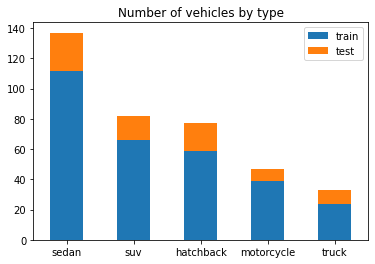

In [155]:
# Split dataset
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_df, y_df, test_size=0.2)

# Count vehicle types
count_train = y_train.apply(pd.value_counts).rename(columns={y_train.columns[0]:'train'}).T
count_test = y_test.apply(pd.value_counts).rename(columns={y_test.columns[0]:'test'}).T

# Plot stacked bar chart
pd.DataFrame([['sedan', count_train[['sedan']].values[0][0], count_test[['sedan']].values[0][0]], 
              ['suv', count_train[['suv']].values[0][0], count_test[['suv']].values[0][0]],
              ['hatchback', count_train[['hatchback']].values[0][0], count_test[['hatchback']].values[0][0]],
              ['motorcycle', count_train[['motorcycle']].values[0][0], count_test[['motorcycle']].values[0][0]],
              ['truck', count_train[['truck']].values[0][0], count_test[['truck']].values[0][0]]],
             columns=['', 'train', 'test']).plot(x='', kind='bar', stacked=True,
                                                 title='Number of vehicles by type', rot=0);

Logistic Regression  Mean: 0.45,  STD: 0.06
Random Forest        Mean: 0.46,  STD: 0.09
SVC                  Mean: 0.37,  STD: 0.01


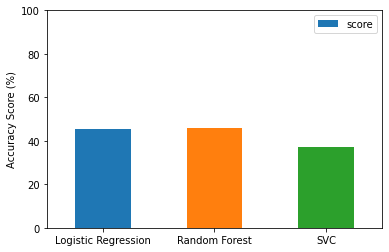

In [156]:
# Classification
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

import matplotlib.pyplot as plt
import seaborn as sns

skf = StratifiedKFold(n_splits=10) # Set stratified 10-fold

accuracy = pd.DataFrame(columns = ["name", "score"]) # Store accuracies

# Save performance analysis
def save_score(name,score):
    accuracy.loc[len(accuracy.index)] = [name, round(np.mean(score)*100, 2)]    
    print(f"{name} ".ljust(20), f"Mean: {score.mean():.2f},".ljust(12), f"STD: {score.std():.2f}")

# Logistic Regression
lrc = LogisticRegression(solver="lbfgs", max_iter=50000)
score = cross_val_score(lrc, X_train, y_train.values.ravel(), cv=skf, n_jobs=1, scoring='accuracy')
save_score("Logistic Regression", score)

# Random Forest Classifier
rfc = RandomForestClassifier()
score = cross_val_score(rfc, X_train, y_train.values.ravel(), cv=skf, n_jobs=1, scoring='accuracy')
save_score("Random Forest", score);

# Support Vector Machine Classifier
svc = SVC()
score = cross_val_score(svc, X_train, y_train.values.ravel(), cv=skf, n_jobs=1, scoring='accuracy')
save_score("SVC", score)

# Plot bar chart
ax = accuracy.plot.bar(x='name', y='score', rot=0, color=['C0', 'C1', 'C2'])
ax.set_ylim(0,100)
ax.set_xlabel("")
ax.set_ylabel("Accuracy Score (%)");